# SpaceNet Buildings v1 Model - Rio

This model **semantically segments buildings** from a given **RGB satellite image**. The model is trained on a dataset comprising of satellite images of the city **Rio de Janerio**. The Dataset is open source and part of the first round of **SpaceNet Buildings Segmentation Challenge**. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2
# import wandb
# from wandb.fastai import WandbCallback

In [0]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1-((2.*intersection+smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [0]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [0]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[:5]) == "3band"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img5750.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6415.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img600.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6329.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img435.tif')]

The **get_y_fn** generates the path for the mask of the image and is passed on to label_from_func. 

In [0]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

Removing the images which don't have any building labels in them.

In [0]:
# ref_img = [x for x in fname if list(open_mask(get_y_fn(x)).data.unique()) == list(tensor([0,1]))]

# string = 'Images/'
# data = [string + x.name for x in ref_img]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Rio_C_buildings.csv")

In [0]:
rio_df = pd.read_csv(path/'Rio_C_buildings.csv')
rio_df = rio_df.drop(columns = 'Unnamed: 0')
rio_df.head()

,Images
0,Images/3band_AOI_1_RIO_img5750.tif
1,Images/3band_AOI_1_RIO_img435.tif
2,Images/3band_AOI_1_RIO_img3455.tif
3,Images/3band_AOI_1_RIO_img5529.tif
4,Images/3band_AOI_1_RIO_img4895.tif


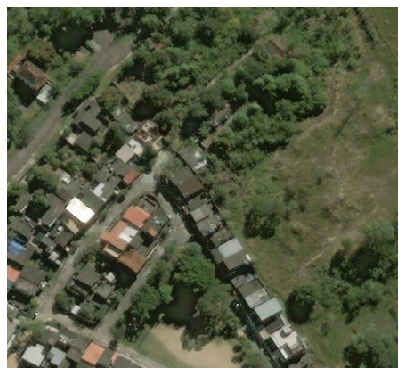

In [0]:
img = open_image(fname[14])
img.show(figsize=(7,7))

It's always better to save the models with an appropriate name.

In [0]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

The **split_by_rand_pct** segregates the dataset into 10% validation (as per the value passed) and 90% training. It is advised to fix a random seed because we don't want our validation set to keep changing everytime we run the model. This way we ensure conlusive results which helps us train the model better.

The **label_from_func** used in segmentation models requires a list of codes to label each pixel. 

In [0]:
random.seed(42)
codes = [0,'building']
src = (SegmentationItemList.from_df(rio_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

We start of with the size of the images as 224 x 224 and we will increase this size once we train our model on the smaller size. 

Also, the Data Augmentation has been elabored on in the Readme of the repository. 

In [0]:
bs = 64
size = 224
data = (src.transform(get_transforms(flip_vert=True, max_rotate=15, max_zoom=1.2, max_lighting=0.5, 
                  xtra_tfms = [brightness(change=0.56, p=1), contrast(scale=(1, 1.75), p=1.)]),
                  size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

It is very important to constantly check the dataset once the databunch is ready in order to be familiar with what we are dealing with. This is also done to ensure everything is in place and we can start training next. 

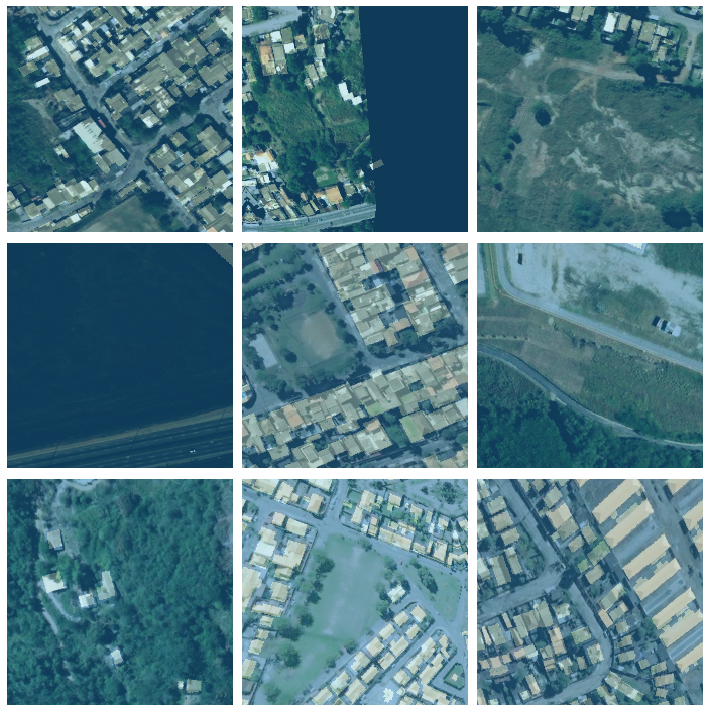

In [0]:
data.show_batch(3, figsize=(10,10))

Since buildings stay same even if the image is a bit blurry, it is good for the training data to be a bit blurry so that the model can train better. Hence **blur** has been turned on. 

**Dice (IoU)** has been set as the metric as it is most appropriate for segmentation models. 

The `to_fp16()` reduces the size of floating point values of the images thereby helping to increase the batch size. (double of what could be accomodated before)

`norm_type=NormType.Weight` and `self_attention=True` have been elaborated upon in the Readme of the repository. 



In [0]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True).to_fp16()
learn.loss = CE_DiceLoss

A pretrained **ResNet34** is used as the encoder to the UNet.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


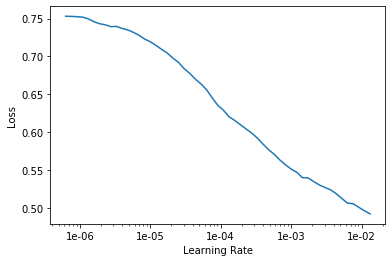

In [0]:
learn.lr_find()
learn.recorder.plot() 

In [0]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.318047,0.281569,0.445776,00:39
1,0.251660,0.215026,0.504926,00:37
2,0.218117,0.212850,0.536133,00:37
3,0.203593,0.201872,0.540033,00:37
4,0.194078,0.200289,0.537439,00:37


In [0]:
save_model(learn, 'Rio_DA', 'F', 'smol', 1)

# Start Recording

In [0]:
import wandb
from wandb.fastai import WandbCallback

The train_loss, validation_loss and dice values along with other hyperparameters are logged onto [Weights and Biases.](https://wandb.com) For this the WandB Callback has to be included in the fastai callback. 

In [0]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True, 
                     callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [0]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Rio.ipynb"

In [0]:
wandb.init(project="spacenet_buildings", name = 'Rio_smol_DAC')

In [0]:
load_model(learn, 'Rio_DA', 'F', 'smol', 1)

In [0]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.190945,0.202218,0.550799,00:38
1,0.190436,0.199058,0.555982,00:37
2,0.188967,0.199098,0.493815,00:37
3,0.189101,0.191532,0.551579,00:37
4,0.189671,0.206634,0.559223,00:37
5,0.190392,0.193848,0.561313,00:37
6,0.184201,0.191912,0.573733,00:37
7,0.181224,0.194613,0.571576,00:37
8,0.177921,0.187843,0.574174,00:37
9,0.174692,0.183929,0.570198,00:37


Better model found at epoch 0 with valid_loss value: 0.2022179365158081.
Better model found at epoch 1 with valid_loss value: 0.19905804097652435.
Better model found at epoch 3 with valid_loss value: 0.19153235852718353.
Better model found at epoch 8 with valid_loss value: 0.1878434270620346.
Better model found at epoch 9 with valid_loss value: 0.18392933905124664.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_155018-xxo7j9wh/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DA', 'F', 'smol', 2)

Initially, the back propagation changes only the last few layers of the ResNet as the starting and middle layers are frozen. Now, model is **unfreezed** so that back propagation changes values of all the layers. 

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.170891,0.183992,0.571400,00:38
1,0.170802,0.184112,0.572845,00:38
2,0.172407,0.184160,0.573825,00:38
3,0.171705,0.182866,0.570399,00:38
4,0.171993,0.183166,0.575072,00:38
5,0.172380,0.183505,0.569648,00:38
6,0.171195,0.185858,0.578974,00:38
7,0.171356,0.182306,0.572660,00:38
8,0.170322,0.181539,0.573449,00:38
9,0.168990,0.182080,0.575912,00:38


Better model found at epoch 0 with valid_loss value: 0.18399237096309662.
Better model found at epoch 3 with valid_loss value: 0.18286634981632233.
Better model found at epoch 7 with valid_loss value: 0.1823057234287262.
Better model found at epoch 8 with valid_loss value: 0.18153923749923706.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_155018-xxo7j9wh/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DA', 'UF', 'smol', 1)

In [0]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.168651,0.181962,0.575833,00:38
1,0.167955,0.181941,0.576557,00:38
2,0.169701,0.182070,0.576688,00:38
3,0.168995,0.182113,0.577104,00:38
4,0.167984,0.182074,0.576954,00:38
5,0.168562,0.181767,0.576420,00:38
6,0.169542,0.181918,0.576638,00:38
7,0.168899,0.181937,0.577482,00:38
8,0.168172,0.181728,0.577552,00:38
9,0.169820,0.181615,0.576653,00:38


Better model found at epoch 0 with valid_loss value: 0.18196216225624084.
Better model found at epoch 1 with valid_loss value: 0.1819409877061844.
Better model found at epoch 5 with valid_loss value: 0.18176725506782532.
Better model found at epoch 8 with valid_loss value: 0.18172809481620789.
Better model found at epoch 9 with valid_loss value: 0.1816152036190033.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_155018-xxo7j9wh/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DAC', 'UF', 'small', 2)

# GO BIG

As a part of the tweaks learned in Fastai course, the size of images are increased after training the model on small sized images. 

In [0]:
bs = 16
size = 400
data = (src.transform(get_transforms(flip_vert=True, max_rotate=15, max_zoom=1.2, max_lighting=0.5, 
                  xtra_tfms = [brightness(change=0.56, p=1), contrast(scale=(1, 1.75), p=1.)]),
                  size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

In [0]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True, 
                     callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [0]:
load_model(learn, 'Rio_DAC', 'UF', 'small', 2)

In [0]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Vegas.ipynb"

In [0]:
wandb.init(project="spacenet_buildings", name = 'Rio_Big_SA_DAC')

In [0]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.172866,0.166984,0.580464,02:18
1,0.178022,0.167842,0.583402,02:02
2,0.179759,0.171175,0.587935,02:02
3,0.172389,0.164668,0.583167,02:02
4,0.172422,0.166465,0.559580,02:03
5,0.174542,0.168590,0.588422,02:02
6,0.176356,0.163486,0.589935,02:02
7,0.169129,0.163318,0.588632,02:02
8,0.167196,0.164962,0.600684,02:02
9,0.165531,0.159606,0.595873,02:02


Better model found at epoch 3 with valid_loss value: 0.16466808319091797.
Better model found at epoch 6 with valid_loss value: 0.16348566114902496.
Better model found at epoch 7 with valid_loss value: 0.1633182317018509.
Better model found at epoch 9 with valid_loss value: 0.15960592031478882.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_161745-kqp9fj5p/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DAC', 'F', 'big', 1)

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.164023,0.159128,0.592639,02:03
1,0.161520,0.159661,0.598517,02:03
2,0.164769,0.159016,0.592948,02:03
3,0.165604,0.158413,0.597865,02:03
4,0.167288,0.157647,0.596551,02:03
5,0.166642,0.158823,0.601453,02:03
6,0.161409,0.158544,0.585434,02:03
7,0.160539,0.157711,0.590052,02:03
8,0.157709,0.157015,0.594382,02:03
9,0.159152,0.157084,0.599597,02:03


Better model found at epoch 0 with valid_loss value: 0.15912757813930511.
Better model found at epoch 2 with valid_loss value: 0.15901634097099304.
Better model found at epoch 3 with valid_loss value: 0.15841296315193176.
Better model found at epoch 4 with valid_loss value: 0.15764689445495605.
Better model found at epoch 8 with valid_loss value: 0.1570151150226593.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_161745-kqp9fj5p/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DAC', 'UF', 'big', 1)

In [0]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.157880,0.151208,0.604605,02:17
1,0.167014,0.151443,0.602957,02:02
2,0.157659,0.151177,0.604076,02:02
3,0.162906,0.152016,0.600101,02:03
4,0.152378,0.152248,0.610111,02:02
5,0.164134,0.151501,0.608065,02:03
6,0.157166,0.151285,0.605029,02:02
7,0.157583,0.151185,0.600582,02:02
8,0.160172,0.150843,0.601618,02:02
9,0.165340,0.151051,0.603837,02:03


Better model found at epoch 0 with valid_loss value: 0.15120834112167358.
Better model found at epoch 2 with valid_loss value: 0.15117661654949188.
Better model found at epoch 8 with valid_loss value: 0.15084347128868103.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_171813-wazul7bs/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DAC', 'UF', 'big', 3)

In [0]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.162333,0.150756,0.602841,02:02
1,0.156122,0.150848,0.604038,02:02
2,0.159552,0.151051,0.604844,02:02
3,0.163908,0.151031,0.605156,02:02
4,0.161821,0.150935,0.603082,02:02
5,0.160741,0.151079,0.604886,02:02
6,0.156260,0.151011,0.606376,02:02
7,0.157663,0.151009,0.602494,02:02
8,0.156310,0.151005,0.605047,02:02
9,0.162411,0.150994,0.603462,02:03


Better model found at epoch 0 with valid_loss value: 0.15075552463531494.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_171813-wazul7bs/bestmodel.pth


In [0]:
save_model(learn, 'Rio_DAC', 'UF', 'big', 3)